# Bonus1

In [58]:
# AND Gate
import torch

class ANDPerceptron(nn.Module):
    def __init__(self):
        super(ANDPerceptron, self).__init__()
        # Define weights and bias
        self.weights = nn.Parameter(torch.tensor([1.0, 1.0]))
        self.bias = nn.Parameter(torch.tensor([-1.5]))

    def forward(self, x):

        weighted_sum = torch.sum(x * self.weights) + self.bias
        # Apply step function
        output = torch.where(
            weighted_sum > 0, torch.tensor(1.0), torch.tensor(0.0))
        return output

# Create an ANDPerceptron
and_perceptron = ANDPerceptron()

# Test
input1 = torch.tensor([0.0, 0.0])
input2 = torch.tensor([1.0, 0.0])
input3 = torch.tensor([0.0, 1.0])
input4 = torch.tensor([1.0, 1.0])

print("Input [0, 0] :", and_perceptron(input1).item())
print("Input [1, 0] :", and_perceptron(input2).item())
print("Input [0, 1] :", and_perceptron(input3).item())
print("Input [1, 1]:", and_perceptron(input4).item())


Input [0, 0] : 0.0
Input [1, 0] : 0.0
Input [0, 1] : 0.0
Input [1, 1]: 1.0


# Part 1 - SLP

In [20]:
# Import libraries
import tqdm
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Unzip dataset
# !unzip '/data.zip' -d '/content'

In [12]:
# Define dataset class with train and validation sets
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root=root_dir, transform=transform)
        self.classes = self.dataset.classes
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return {'image': img[0,:,:], 'label': label}

# Define transformations
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor()])

# Create datasets
train_dataset = CustomDataset(
    root_dir='/content/FER-2013/FER-2013/train', transform=transform)

valid_dataset = CustomDataset(
    root_dir='/content/FER-2013/FER-2013/val', transform=transform)

test_dataset = CustomDataset(
    root_dir='/content/FER-2013/FER-2013/test', transform=transform)

# Create dataloadrs
train_loader = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True)

valid_loader = DataLoader(
    dataset=valid_dataset, batch_size=64, shuffle=False)

test_loader = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False)

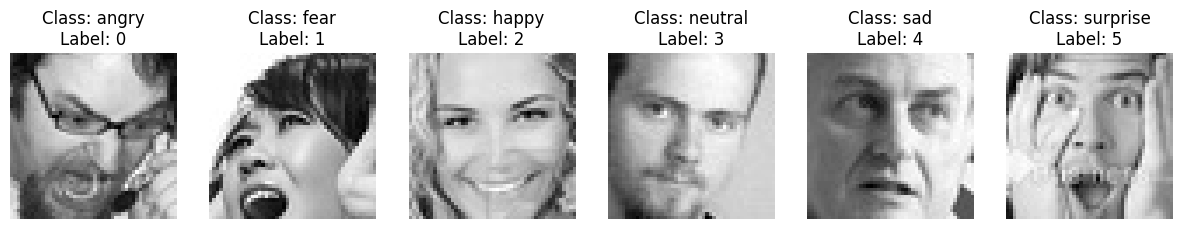

In [15]:
# Function to show image from each class
def plot_one_image_per_class(loader, classes):

    fig, axs = plt.subplots(1, len(classes), figsize=(15, 3))

    # Iterate over each class
    for i, class_name in enumerate(classes):

        # Find the index of the first sample in the loader corresponding to the class
        class_indices = [idx for idx, label in enumerate(loader.dataset.dataset.targets) if label == i]
        idx = class_indices[0]

        # Get the image and label
        sample = loader.dataset[idx]
        image, label = sample['image'], sample['label']

        # Plot the image
        axs[i].imshow(image, cmap = 'gray')
        axs[i].set_title(f'Class: {class_name}\nLabel: {label}')
        axs[i].axis('off')

    plt.show()

plot_one_image_per_class(valid_loader, valid_dataset.classes)

In [21]:
# Training Function
def train_loop(model, train_loader, criterion, optimizer, device):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in tqdm.tqdm(train_loader):
        images, labels = batch['image'].to(device), batch['label'].to(device)
        images = images.view(images.size(0), -1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    return avg_train_loss, train_accuracy

# Validation Function
def valid_loop(model, valid_loader, criterion, device):
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for batch in valid_loader:
            images, labels = batch['image'].to(device), batch['label'].to(device)
            images = images.view(images.size(0), -1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_valid_loss += loss.item()
            _, predicted_valid = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted_valid == labels).sum().item()

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_accuracy = correct_valid / total_valid

    return avg_valid_loss, valid_accuracy


# Test Function
def test_loop(model, test_loader, device):
    model.eval()
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['image'].to(device), batch['label'].to(device)
            images = images.view(images.size(0), -1)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    test_accuracy = accuracy_score(all_labels, all_predicted)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predicted)

    return test_accuracy, conf_matrix

In [41]:
def visualize_loss_and_acc(train_loss, train_acc, val_loss, val_acc):

    epochs = range(1, len(train_acc) + 1)
    f = plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, 'r-', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, 'r-', label= 'Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label= 'Validation Accuracy')
    plt.title('Training and validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [42]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [43]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 48 * 48
output_size = 6

model = MLP(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training, validation, and test loss and accuracy
train_loss_history = []
train_acc_history = []
valid_loss_history = []
valid_acc_history = []
test_loss_history = []
test_acc_history = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    avg_train_loss, train_accuracy = train_loop(model, train_loader, criterion, optimizer, device)
    avg_valid_loss, valid_accuracy = valid_loop(model, valid_loader, criterion, device)

    # Print and store results
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy * 100:.2f}%, '
          f'Validation Loss: {avg_valid_loss:.4f}, '
          f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)
    valid_loss_history.append(avg_valid_loss)
    valid_acc_history.append(valid_accuracy)

100%|██████████| 442/442 [00:12<00:00, 34.08it/s]


Epoch [1/10], Train Loss: 1.7280, Train Accuracy: 29.43%, Validation Loss: 1.6996, Validation Accuracy: 30.62%


100%|██████████| 442/442 [00:11<00:00, 38.09it/s]


Epoch [2/10], Train Loss: 1.6642, Train Accuracy: 33.25%, Validation Loss: 1.6903, Validation Accuracy: 32.88%


100%|██████████| 442/442 [00:12<00:00, 35.60it/s]


Epoch [3/10], Train Loss: 1.6411, Train Accuracy: 34.81%, Validation Loss: 1.6503, Validation Accuracy: 33.53%


100%|██████████| 442/442 [00:11<00:00, 37.83it/s]


Epoch [4/10], Train Loss: 1.6371, Train Accuracy: 34.89%, Validation Loss: 1.6774, Validation Accuracy: 35.43%


100%|██████████| 442/442 [00:14<00:00, 30.37it/s]


Epoch [5/10], Train Loss: 1.6243, Train Accuracy: 35.68%, Validation Loss: 1.6598, Validation Accuracy: 36.39%


100%|██████████| 442/442 [00:11<00:00, 37.85it/s]


Epoch [6/10], Train Loss: 1.6098, Train Accuracy: 36.05%, Validation Loss: 1.6047, Validation Accuracy: 36.53%


100%|██████████| 442/442 [00:18<00:00, 23.49it/s]


Epoch [7/10], Train Loss: 1.6067, Train Accuracy: 36.39%, Validation Loss: 1.6406, Validation Accuracy: 34.52%


100%|██████████| 442/442 [00:15<00:00, 29.03it/s]


Epoch [8/10], Train Loss: 1.6038, Train Accuracy: 36.60%, Validation Loss: 1.6247, Validation Accuracy: 35.51%


100%|██████████| 442/442 [00:15<00:00, 28.43it/s]


Epoch [9/10], Train Loss: 1.6005, Train Accuracy: 36.69%, Validation Loss: 1.6045, Validation Accuracy: 36.62%


100%|██████████| 442/442 [00:11<00:00, 37.88it/s]


Epoch [10/10], Train Loss: 1.6008, Train Accuracy: 36.36%, Validation Loss: 1.6384, Validation Accuracy: 36.19%


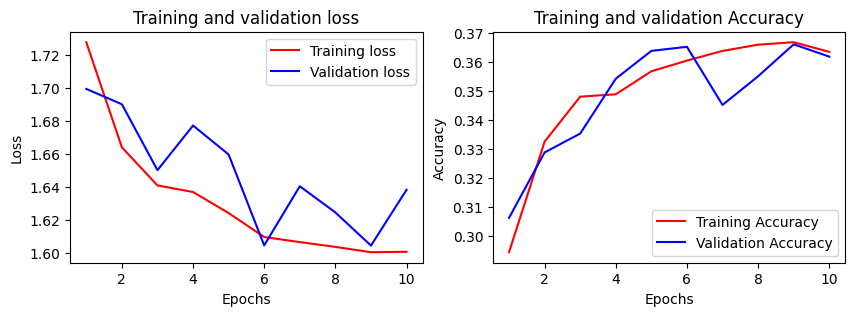

In [44]:
# Plot train/val results
visualize_loss_and_acc(train_loss_history, train_acc_history,
                       valid_loss_history, valid_acc_history)

Test Accuracy: 37.11%


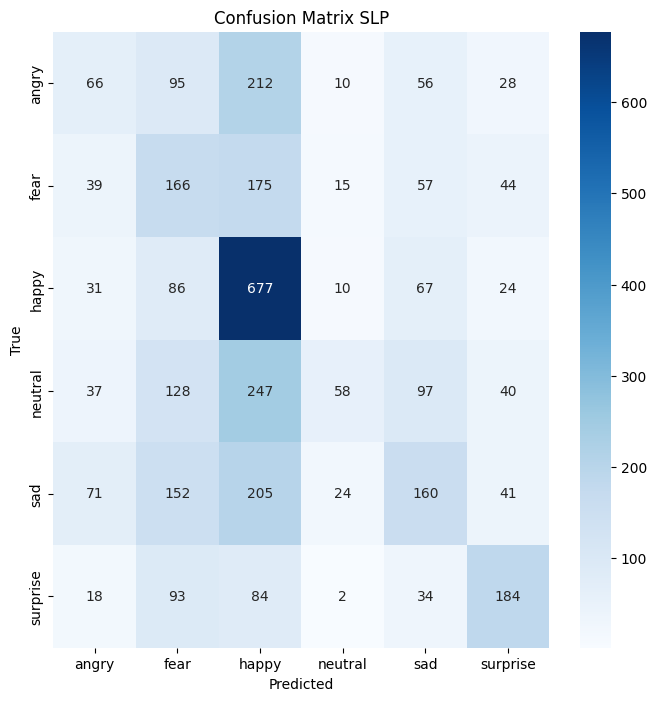

In [45]:
# Test loop
test_accuracy, conf_matrix = test_loop(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix SLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

- Test Accuracy: 37.11%

# Part 2 - MLP

In [50]:
# MLP with hidden layer
class MLPWithHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPWithHiddenLayer, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 32)
        self.fc3 = nn.Linear(32,  output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Set sizes
input_size = 48 * 48
hidden_size = 128
output_size = 6

model_with_hidden = MLPWithHiddenLayer(input_size, hidden_size, output_size).to(device)

# Set loss function and optimizer
criterion_with_hidden = nn.CrossEntropyLoss()
optimizer_with_hidden = optim.Adam(model_with_hidden.parameters(), lr=0.001)

# Lists to store training and validation loss and accuracy
train_loss_history_with_hidden = []
train_acc_history_with_hidden = []
valid_loss_history_with_hidden = []
valid_acc_history_with_hidden = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_with_hidden.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in tqdm.tqdm(train_loader):
        images, labels = batch['image'].to(device), batch['label'].to(device)
        images = images.view(images.size(0), -1)

        optimizer_with_hidden.zero_grad()
        outputs = model_with_hidden(images)
        loss = criterion_with_hidden(outputs, labels)
        loss.backward()
        optimizer_with_hidden.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model_with_hidden.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for batch in valid_loader:
            images, labels = batch['image'].to(device), batch['label'].to(device)
            images = images.view(images.size(0), -1)

            outputs = model_with_hidden(images)
            loss = criterion_with_hidden(outputs, labels)

            total_valid_loss += loss.item()
            _, predicted_valid = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted_valid == labels).sum().item()

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_accuracy = correct_valid / total_valid

    # Print and store results
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy * 100:.2f}%, '
          f'Validation Loss: {avg_valid_loss:.4f}, '
          f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    train_loss_history_with_hidden.append(avg_train_loss)
    train_acc_history_with_hidden.append(train_accuracy)
    valid_loss_history_with_hidden.append(avg_valid_loss)
    valid_acc_history_with_hidden.append(valid_accuracy)


100%|██████████| 442/442 [00:12<00:00, 36.78it/s]


Epoch [1/10], Train Loss: 1.7266, Train Accuracy: 27.53%, Validation Loss: 1.6723, Validation Accuracy: 33.39%


100%|██████████| 442/442 [00:12<00:00, 36.51it/s]


Epoch [2/10], Train Loss: 1.6430, Train Accuracy: 33.16%, Validation Loss: 1.6075, Validation Accuracy: 35.48%


100%|██████████| 442/442 [00:17<00:00, 25.71it/s]


Epoch [3/10], Train Loss: 1.6138, Train Accuracy: 34.91%, Validation Loss: 1.6042, Validation Accuracy: 36.62%


100%|██████████| 442/442 [00:15<00:00, 28.74it/s]


Epoch [4/10], Train Loss: 1.5894, Train Accuracy: 36.18%, Validation Loss: 1.5682, Validation Accuracy: 37.35%


100%|██████████| 442/442 [00:14<00:00, 30.55it/s]


Epoch [5/10], Train Loss: 1.5749, Train Accuracy: 36.73%, Validation Loss: 1.5816, Validation Accuracy: 36.81%


100%|██████████| 442/442 [00:15<00:00, 28.06it/s]


Epoch [6/10], Train Loss: 1.5630, Train Accuracy: 37.33%, Validation Loss: 1.5557, Validation Accuracy: 37.86%


100%|██████████| 442/442 [00:18<00:00, 23.52it/s]


Epoch [7/10], Train Loss: 1.5515, Train Accuracy: 37.64%, Validation Loss: 1.5548, Validation Accuracy: 37.49%


100%|██████████| 442/442 [00:17<00:00, 25.70it/s]


Epoch [8/10], Train Loss: 1.5380, Train Accuracy: 38.34%, Validation Loss: 1.5393, Validation Accuracy: 37.97%


100%|██████████| 442/442 [00:13<00:00, 33.45it/s]


Epoch [9/10], Train Loss: 1.5293, Train Accuracy: 38.97%, Validation Loss: 1.5577, Validation Accuracy: 37.15%


100%|██████████| 442/442 [00:12<00:00, 36.79it/s]


Epoch [10/10], Train Loss: 1.5250, Train Accuracy: 39.19%, Validation Loss: 1.5283, Validation Accuracy: 39.84%


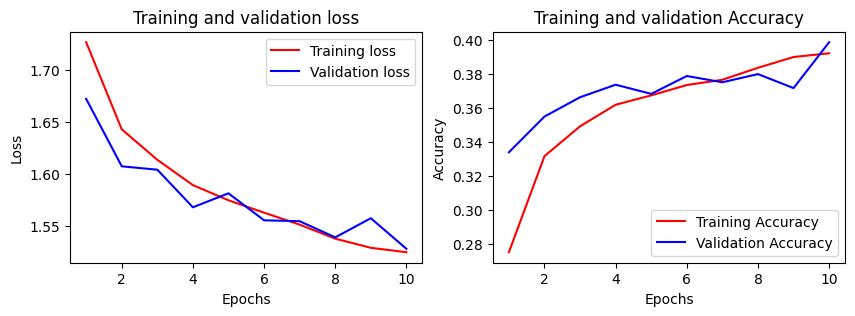

In [51]:
# Plot train/val results
visualize_loss_and_acc(
    train_loss_history_with_hidden, train_acc_history_with_hidden,
    valid_loss_history_with_hidden, valid_acc_history_with_hidden)

Test Accuracy: 39.48%


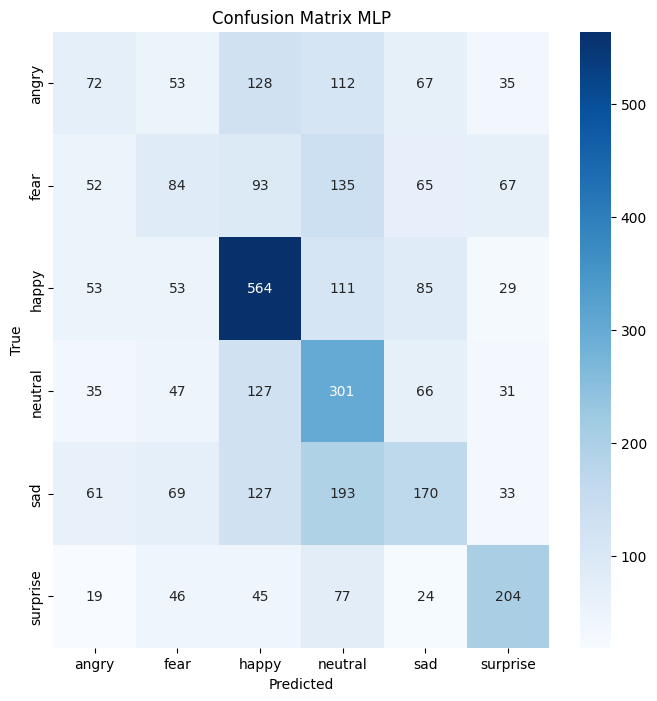

In [52]:
# Test loop
test_accuracy, conf_matrix = test_loop(model_with_hidden, test_loader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix MLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**As you see the model performance got better when I added more FC layers and make the model more complicated. The loss decreased and the accuracy increased.**

- Test Accuracy: 39.48%

# Part 3 - Optimizer, batch, epoch

In [53]:
# More epochs
model_with_hidden = MLPWithHiddenLayer(input_size, hidden_size, output_size).to(device)

# Set loss function and optimizer
criterion_with_hidden = nn.CrossEntropyLoss()
optimizer_with_hidden = optim.Adam(model_with_hidden.parameters(), lr=0.001)

# Lists to store training and validation loss and accuracy
train_loss_history_with_hidden = []
train_acc_history_with_hidden = []
valid_loss_history_with_hidden = []
valid_acc_history_with_hidden = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model_with_hidden.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in tqdm.tqdm(train_loader):
        images, labels = batch['image'].to(device), batch['label'].to(device)
        images = images.view(images.size(0), -1)

        optimizer_with_hidden.zero_grad()
        outputs = model_with_hidden(images)
        loss = criterion_with_hidden(outputs, labels)
        loss.backward()
        optimizer_with_hidden.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model_with_hidden.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for batch in valid_loader:
            images, labels = batch['image'].to(device), batch['label'].to(device)
            images = images.view(images.size(0), -1)

            outputs = model_with_hidden(images)
            loss = criterion_with_hidden(outputs, labels)

            total_valid_loss += loss.item()
            _, predicted_valid = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted_valid == labels).sum().item()

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_accuracy = correct_valid / total_valid

    # Print and store results
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy * 100:.2f}%, '
          f'Validation Loss: {avg_valid_loss:.4f}, '
          f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    train_loss_history_with_hidden.append(avg_train_loss)
    train_acc_history_with_hidden.append(train_accuracy)
    valid_loss_history_with_hidden.append(avg_valid_loss)
    valid_acc_history_with_hidden.append(valid_accuracy)

100%|██████████| 442/442 [00:13<00:00, 33.13it/s]


Epoch [1/30], Train Loss: 1.7171, Train Accuracy: 28.82%, Validation Loss: 1.6552, Validation Accuracy: 32.63%


100%|██████████| 442/442 [00:12<00:00, 34.53it/s]


Epoch [2/30], Train Loss: 1.6436, Train Accuracy: 33.58%, Validation Loss: 1.6314, Validation Accuracy: 34.44%


100%|██████████| 442/442 [00:13<00:00, 31.76it/s]


Epoch [3/30], Train Loss: 1.6117, Train Accuracy: 35.37%, Validation Loss: 1.6025, Validation Accuracy: 35.60%


100%|██████████| 442/442 [00:12<00:00, 36.73it/s]


Epoch [4/30], Train Loss: 1.5914, Train Accuracy: 36.31%, Validation Loss: 1.5771, Validation Accuracy: 36.81%


100%|██████████| 442/442 [00:16<00:00, 26.58it/s]


Epoch [5/30], Train Loss: 1.5793, Train Accuracy: 36.56%, Validation Loss: 1.5847, Validation Accuracy: 37.49%


100%|██████████| 442/442 [00:18<00:00, 23.71it/s]


Epoch [6/30], Train Loss: 1.5638, Train Accuracy: 37.12%, Validation Loss: 1.5539, Validation Accuracy: 37.52%


100%|██████████| 442/442 [00:12<00:00, 36.18it/s]


Epoch [7/30], Train Loss: 1.5522, Train Accuracy: 37.61%, Validation Loss: 1.5607, Validation Accuracy: 35.94%


100%|██████████| 442/442 [00:13<00:00, 32.98it/s]


Epoch [8/30], Train Loss: 1.5394, Train Accuracy: 38.63%, Validation Loss: 1.5365, Validation Accuracy: 38.85%


100%|██████████| 442/442 [00:12<00:00, 36.49it/s]


Epoch [9/30], Train Loss: 1.5303, Train Accuracy: 38.94%, Validation Loss: 1.5303, Validation Accuracy: 38.54%


100%|██████████| 442/442 [00:12<00:00, 36.78it/s]


Epoch [10/30], Train Loss: 1.5251, Train Accuracy: 38.91%, Validation Loss: 1.5415, Validation Accuracy: 37.72%


100%|██████████| 442/442 [00:12<00:00, 34.31it/s]


Epoch [11/30], Train Loss: 1.5124, Train Accuracy: 39.85%, Validation Loss: 1.5280, Validation Accuracy: 38.14%


100%|██████████| 442/442 [00:13<00:00, 32.80it/s]


Epoch [12/30], Train Loss: 1.5111, Train Accuracy: 39.53%, Validation Loss: 1.5321, Validation Accuracy: 38.74%


100%|██████████| 442/442 [00:11<00:00, 37.06it/s]


Epoch [13/30], Train Loss: 1.5018, Train Accuracy: 40.05%, Validation Loss: 1.5409, Validation Accuracy: 36.96%


100%|██████████| 442/442 [00:12<00:00, 36.54it/s]


Epoch [14/30], Train Loss: 1.4960, Train Accuracy: 40.22%, Validation Loss: 1.5218, Validation Accuracy: 38.74%


100%|██████████| 442/442 [00:12<00:00, 35.16it/s]


Epoch [15/30], Train Loss: 1.4886, Train Accuracy: 40.76%, Validation Loss: 1.5215, Validation Accuracy: 38.77%


100%|██████████| 442/442 [00:12<00:00, 35.93it/s]


Epoch [16/30], Train Loss: 1.4802, Train Accuracy: 41.32%, Validation Loss: 1.5417, Validation Accuracy: 38.71%


100%|██████████| 442/442 [00:11<00:00, 37.06it/s]


Epoch [17/30], Train Loss: 1.4778, Train Accuracy: 41.20%, Validation Loss: 1.5230, Validation Accuracy: 38.46%


100%|██████████| 442/442 [00:11<00:00, 37.62it/s]


Epoch [18/30], Train Loss: 1.4719, Train Accuracy: 41.48%, Validation Loss: 1.5057, Validation Accuracy: 39.73%


100%|██████████| 442/442 [00:12<00:00, 34.46it/s]


Epoch [19/30], Train Loss: 1.4645, Train Accuracy: 41.94%, Validation Loss: 1.5057, Validation Accuracy: 39.56%


100%|██████████| 442/442 [00:11<00:00, 36.89it/s]


Epoch [20/30], Train Loss: 1.4618, Train Accuracy: 41.93%, Validation Loss: 1.5092, Validation Accuracy: 39.42%


100%|██████████| 442/442 [00:12<00:00, 34.43it/s]


Epoch [21/30], Train Loss: 1.4547, Train Accuracy: 42.41%, Validation Loss: 1.5070, Validation Accuracy: 40.61%


100%|██████████| 442/442 [00:11<00:00, 36.87it/s]


Epoch [22/30], Train Loss: 1.4504, Train Accuracy: 42.64%, Validation Loss: 1.5177, Validation Accuracy: 40.10%


100%|██████████| 442/442 [00:15<00:00, 27.68it/s]


Epoch [23/30], Train Loss: 1.4424, Train Accuracy: 43.13%, Validation Loss: 1.5080, Validation Accuracy: 40.52%


100%|██████████| 442/442 [00:14<00:00, 30.24it/s]


Epoch [24/30], Train Loss: 1.4446, Train Accuracy: 42.98%, Validation Loss: 1.5178, Validation Accuracy: 39.25%


100%|██████████| 442/442 [00:14<00:00, 30.88it/s]


Epoch [25/30], Train Loss: 1.4337, Train Accuracy: 43.27%, Validation Loss: 1.5025, Validation Accuracy: 40.78%


100%|██████████| 442/442 [00:19<00:00, 23.23it/s]


Epoch [26/30], Train Loss: 1.4307, Train Accuracy: 43.48%, Validation Loss: 1.5698, Validation Accuracy: 37.41%


100%|██████████| 442/442 [00:12<00:00, 36.39it/s]


Epoch [27/30], Train Loss: 1.4273, Train Accuracy: 43.68%, Validation Loss: 1.5046, Validation Accuracy: 40.21%


100%|██████████| 442/442 [00:12<00:00, 36.68it/s]


Epoch [28/30], Train Loss: 1.4217, Train Accuracy: 44.13%, Validation Loss: 1.5063, Validation Accuracy: 40.29%


100%|██████████| 442/442 [00:21<00:00, 20.15it/s]


Epoch [29/30], Train Loss: 1.4209, Train Accuracy: 44.17%, Validation Loss: 1.4924, Validation Accuracy: 41.40%


100%|██████████| 442/442 [00:18<00:00, 24.36it/s]


Epoch [30/30], Train Loss: 1.4155, Train Accuracy: 44.11%, Validation Loss: 1.5265, Validation Accuracy: 39.87%


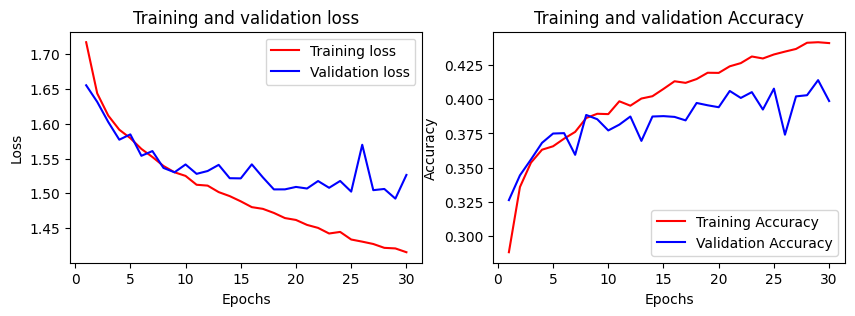

In [54]:
# Plot train/val results
visualize_loss_and_acc(
    train_loss_history_with_hidden, train_acc_history_with_hidden,
    valid_loss_history_with_hidden, valid_acc_history_with_hidden)

Test Accuracy: 40.22%


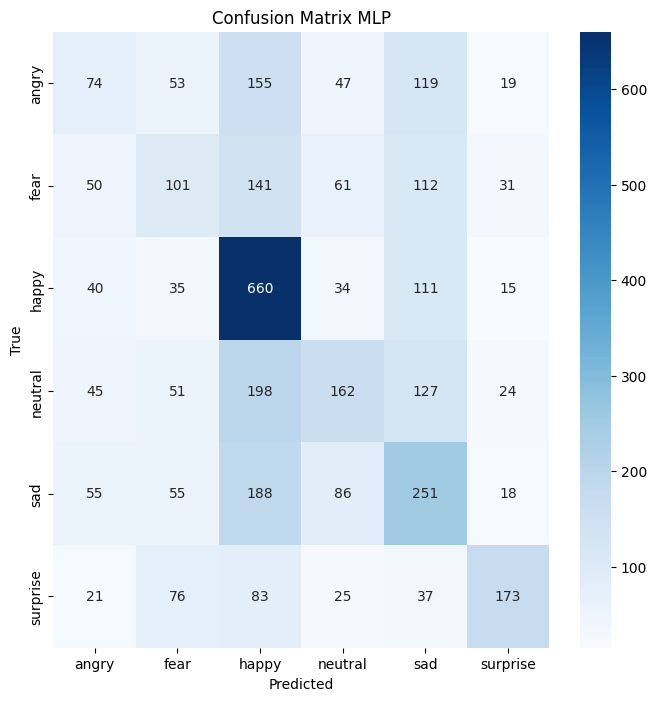

In [55]:
# Test loop
test_accuracy, conf_matrix = test_loop(model_with_hidden, test_loader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix MLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**As you see with more epochs the model performance gets better but the model leads to overfitting, So we should track the validation loss/acc to prevent this situation.**

- Test Accuracy: 40.22%

In [56]:
# Batch size effect

# Create dataloadrs with batch size=2
train_loader_2 = DataLoader(
    dataset=train_dataset, batch_size=2, shuffle=True)

valid_loader_2 = DataLoader(
    dataset=valid_dataset, batch_size=2, shuffle=False)

test_loader_2 = DataLoader(
    dataset=test_dataset, batch_size=2, shuffle=False)




model_with_hidden = MLPWithHiddenLayer(input_size, hidden_size, output_size).to(device)

# Set loss function and optimizer
criterion_with_hidden = nn.CrossEntropyLoss()
optimizer_with_hidden = optim.Adam(model_with_hidden.parameters(), lr=0.001)

# Lists to store training and validation loss and accuracy
train_loss_history_with_hidden = []
train_acc_history_with_hidden = []
valid_loss_history_with_hidden = []
valid_acc_history_with_hidden = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_with_hidden.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in tqdm.tqdm(train_loader_2):
        images, labels = batch['image'].to(device), batch['label'].to(device)
        images = images.view(images.size(0), -1)

        optimizer_with_hidden.zero_grad()
        outputs = model_with_hidden(images)
        loss = criterion_with_hidden(outputs, labels)
        loss.backward()
        optimizer_with_hidden.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model_with_hidden.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for batch in valid_loader_2:
            images, labels = batch['image'].to(device), batch['label'].to(device)
            images = images.view(images.size(0), -1)

            outputs = model_with_hidden(images)
            loss = criterion_with_hidden(outputs, labels)

            total_valid_loss += loss.item()
            _, predicted_valid = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted_valid == labels).sum().item()

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_accuracy = correct_valid / total_valid

    # Print and store results
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy * 100:.2f}%, '
          f'Validation Loss: {avg_valid_loss:.4f}, '
          f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    train_loss_history_with_hidden.append(avg_train_loss)
    train_acc_history_with_hidden.append(train_accuracy)
    valid_loss_history_with_hidden.append(avg_valid_loss)
    valid_acc_history_with_hidden.append(valid_accuracy)

100%|██████████| 14137/14137 [00:46<00:00, 302.59it/s]


Epoch [1/10], Train Loss: 54.7720, Train Accuracy: 28.31%, Validation Loss: 52.2501, Validation Accuracy: 33.87%


100%|██████████| 14137/14137 [00:40<00:00, 348.67it/s]


Epoch [2/10], Train Loss: 52.7914, Train Accuracy: 32.41%, Validation Loss: 51.1629, Validation Accuracy: 34.72%


100%|██████████| 14137/14137 [00:45<00:00, 308.66it/s]


Epoch [3/10], Train Loss: 52.3220, Train Accuracy: 33.20%, Validation Loss: 51.7489, Validation Accuracy: 32.31%


100%|██████████| 14137/14137 [00:45<00:00, 308.71it/s]


Epoch [4/10], Train Loss: 52.0586, Train Accuracy: 33.61%, Validation Loss: 50.9276, Validation Accuracy: 34.61%


100%|██████████| 14137/14137 [00:46<00:00, 306.46it/s]


Epoch [5/10], Train Loss: 51.7774, Train Accuracy: 33.77%, Validation Loss: 50.7129, Validation Accuracy: 34.44%


100%|██████████| 14137/14137 [00:42<00:00, 336.30it/s]


Epoch [6/10], Train Loss: 51.7444, Train Accuracy: 34.39%, Validation Loss: 51.1319, Validation Accuracy: 34.18%


100%|██████████| 14137/14137 [00:40<00:00, 353.02it/s]


Epoch [7/10], Train Loss: 51.5924, Train Accuracy: 34.27%, Validation Loss: 50.7267, Validation Accuracy: 35.17%


100%|██████████| 14137/14137 [00:40<00:00, 345.19it/s]


Epoch [8/10], Train Loss: 51.5089, Train Accuracy: 34.63%, Validation Loss: 51.3360, Validation Accuracy: 33.96%


100%|██████████| 14137/14137 [00:41<00:00, 343.58it/s]


Epoch [9/10], Train Loss: 51.3622, Train Accuracy: 34.51%, Validation Loss: 51.1994, Validation Accuracy: 33.84%


100%|██████████| 14137/14137 [00:47<00:00, 299.04it/s]


Epoch [10/10], Train Loss: 51.3207, Train Accuracy: 34.62%, Validation Loss: 50.8800, Validation Accuracy: 33.93%


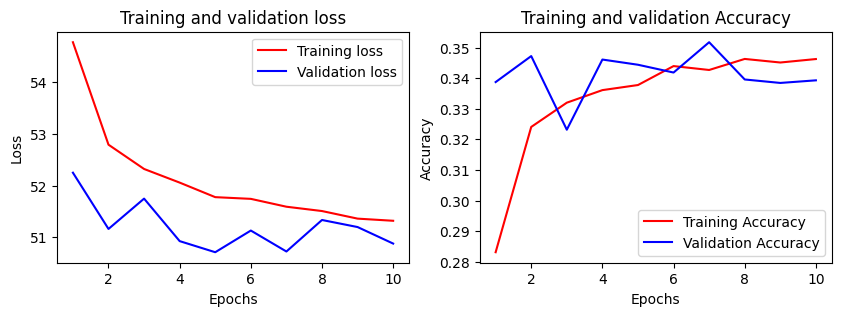

In [57]:
# Plot train/val results
visualize_loss_and_acc(
    train_loss_history_with_hidden, train_acc_history_with_hidden,
    valid_loss_history_with_hidden, valid_acc_history_with_hidden)

**With smaller batches, we have more oscillation during optimization. And also the model training time increases. Acctually the model optimization process takes more time, for exmaple with batch size=64 I got 37% accuracy in 7th epoch, but in this part with batch size=2 I got 34% Accuracy in the same epoch. With larger barch size we have more informative batches and better updates in each step**

# Part 4 - CNN

In [64]:
# Define dataset class with train and validation sets
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root=root_dir, transform=transform)
        self.classes = self.dataset.classes
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return {'image': img, 'label': label}

# Define transformations
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor()])

# Create datasets
train_dataset = CustomDataset(
    root_dir='/content/FER-2013/FER-2013/train', transform=transform)

valid_dataset = CustomDataset(
    root_dir='/content/FER-2013/FER-2013/val', transform=transform)

test_dataset = CustomDataset(
    root_dir='/content/FER-2013/FER-2013/test', transform=transform)

# Create dataloadrs
train_loader_c = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True)

valid_loader_c = DataLoader(
    dataset=valid_dataset, batch_size=64, shuffle=False)

test_loader_c = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False)

In [83]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 12 * 12, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# Instantiate the CNN model
cnn_model = SimpleCNN(num_classes=6).to(device)

# Instantiate the loss function and optimizer
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

# Lists to store training and validation loss and accuracy
train_loss_history_cnn = []
train_acc_history_cnn = []
valid_loss_history_cnn = []
valid_acc_history_cnn = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    cnn_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in tqdm.tqdm(train_loader_c):
        images, labels = batch['image'].to(device), batch['label'].to(device)

        optimizer_cnn.zero_grad()
        outputs = cnn_model(images)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    cnn_model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for batch in valid_loader_c:
            images, labels = batch['image'].to(device), batch['label'].to(device)

            outputs = cnn_model(images)
            loss = criterion_cnn(outputs, labels)

            total_valid_loss += loss.item()
            _, predicted_valid = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted_valid == labels).sum().item()

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_accuracy = correct_valid / total_valid

    # Print and store results
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy * 100:.2f}%, '
          f'Validation Loss: {avg_valid_loss:.4f}, '
          f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    train_loss_history_cnn.append(avg_train_loss)
    train_acc_history_cnn.append(train_accuracy)
    valid_loss_history_cnn.append(avg_valid_loss)
    valid_acc_history_cnn.append(valid_accuracy)


100%|██████████| 442/442 [00:14<00:00, 31.53it/s]


Epoch [1/10], Train Loss: 1.5618, Train Accuracy: 37.71%, Validation Loss: 1.4213, Validation Accuracy: 45.22%


100%|██████████| 442/442 [00:13<00:00, 33.12it/s]


Epoch [2/10], Train Loss: 1.3650, Train Accuracy: 47.63%, Validation Loss: 1.3429, Validation Accuracy: 47.68%


100%|██████████| 442/442 [00:13<00:00, 33.46it/s]


Epoch [3/10], Train Loss: 1.2752, Train Accuracy: 51.20%, Validation Loss: 1.2997, Validation Accuracy: 49.92%


100%|██████████| 442/442 [00:14<00:00, 30.20it/s]


Epoch [4/10], Train Loss: 1.2085, Train Accuracy: 54.05%, Validation Loss: 1.2807, Validation Accuracy: 50.96%


100%|██████████| 442/442 [00:13<00:00, 33.52it/s]


Epoch [5/10], Train Loss: 1.1501, Train Accuracy: 56.71%, Validation Loss: 1.2601, Validation Accuracy: 52.07%


100%|██████████| 442/442 [00:14<00:00, 30.84it/s]


Epoch [6/10], Train Loss: 1.0976, Train Accuracy: 58.77%, Validation Loss: 1.2384, Validation Accuracy: 52.46%


100%|██████████| 442/442 [00:18<00:00, 23.63it/s]


Epoch [7/10], Train Loss: 1.0448, Train Accuracy: 61.10%, Validation Loss: 1.2419, Validation Accuracy: 53.42%


100%|██████████| 442/442 [00:16<00:00, 27.10it/s]


Epoch [8/10], Train Loss: 1.0005, Train Accuracy: 62.63%, Validation Loss: 1.2703, Validation Accuracy: 51.53%


100%|██████████| 442/442 [00:13<00:00, 33.51it/s]


Epoch [9/10], Train Loss: 0.9546, Train Accuracy: 64.84%, Validation Loss: 1.2604, Validation Accuracy: 52.74%


100%|██████████| 442/442 [00:13<00:00, 33.44it/s]


Epoch [10/10], Train Loss: 0.9179, Train Accuracy: 66.49%, Validation Loss: 1.2798, Validation Accuracy: 53.25%


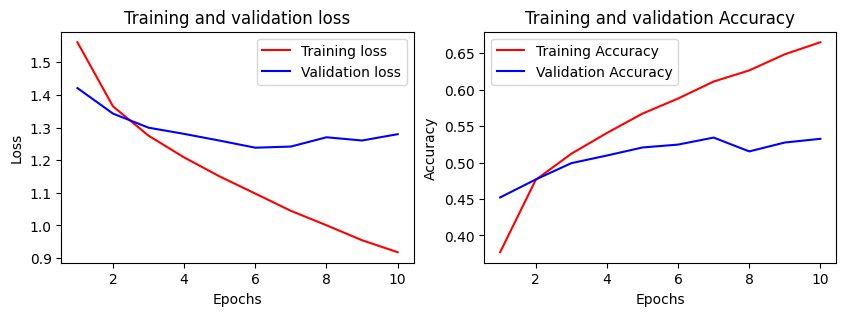

In [84]:
# Plot train/val results
visualize_loss_and_acc(train_loss_history_cnn, train_acc_history_cnn,
                       valid_loss_history_cnn, valid_acc_history_cnn)

In [85]:
# Function to test CNNs and generate confusion matrix
def test_model(model, test_loader, criterion, device):
    model.eval()
    all_predicted = []
    all_labels = []
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['image'].to(device), batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total

    return accuracy, avg_loss, all_labels, all_predicted

Simple CNN Test Accuracy: 52.504953297480895
Simple CNN Test Loss: 1.3077616393566132


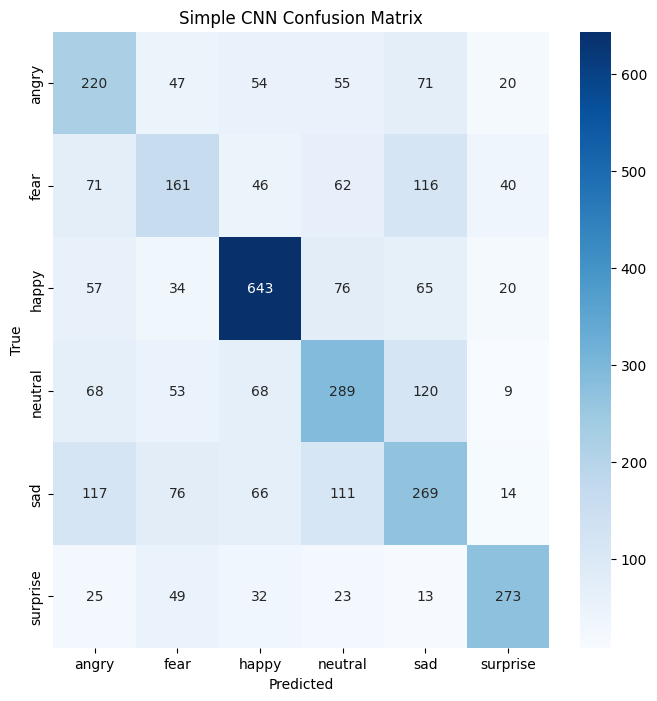

In [86]:
# Test SimpleCNN
simple_cnn_accuracy, simple_cnn_loss, simple_cnn_labels, simple_cnn_predicted = test_model(
    cnn_model, test_loader_c, criterion_cnn, device)


# Report results
print('Simple CNN Test Accuracy:', simple_cnn_accuracy * 100)
print('Simple CNN Test Loss:', simple_cnn_loss)


# Plot confusion matrix for Simple CNN
plt.figure(figsize=(8, 8))
conf_matrix_simple_cnn = confusion_matrix(simple_cnn_labels, simple_cnn_predicted)
sns.heatmap(conf_matrix_simple_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Simple CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

- Test Accuracy: 52.50%

In [94]:
# Define an extended CNN model
class ExtendedCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(ExtendedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x =self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the extended CNN model
extended_cnn_model = ExtendedCNN(num_classes=6).to(device)

# Instantiate the loss function and optimizer
criterion_extended_cnn = nn.CrossEntropyLoss()
optimizer_extended_cnn = optim.Adam(extended_cnn_model.parameters(), lr=0.001)

# Lists to store training and validation loss and accuracy
train_loss_history_extended_cnn = []
train_acc_history_extended_cnn = []
valid_loss_history_extended_cnn = []
valid_acc_history_extended_cnn = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    extended_cnn_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in tqdm.tqdm(train_loader_c):
        images, labels = batch['image'].to(device), batch['label'].to(device)

        optimizer_extended_cnn.zero_grad()
        outputs = extended_cnn_model(images)
        loss = criterion_extended_cnn(outputs, labels)
        loss.backward()
        optimizer_extended_cnn.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    extended_cnn_model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for batch in tqdm.tqdm(valid_loader_c):
            images, labels = batch['image'].to(device), batch['label'].to(device)

            outputs = extended_cnn_model(images)
            loss = criterion_extended_cnn(outputs, labels)

            total_valid_loss += loss.item()
            _, predicted_valid = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted_valid == labels).sum().item()

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_accuracy = correct_valid / total_valid

    # Print and store results
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy * 100:.2f}%, '
          f'Validation Loss: {avg_valid_loss:.4f}, '
          f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    train_loss_history_extended_cnn.append(avg_train_loss)
    train_acc_history_extended_cnn.append(train_accuracy)
    valid_loss_history_extended_cnn.append(avg_valid_loss)
    valid_acc_history_extended_cnn.append(valid_accuracy)


100%|██████████| 56/56 [00:01<00:00, 40.83it/s]


Epoch [1/10], Train Loss: 1.6852, Train Accuracy: 28.98%, Validation Loss: 1.5363, Validation Accuracy: 36.64%


100%|██████████| 56/56 [00:01<00:00, 30.73it/s]


Epoch [2/10], Train Loss: 1.4272, Train Accuracy: 42.69%, Validation Loss: 1.3452, Validation Accuracy: 45.78%


100%|██████████| 56/56 [00:01<00:00, 40.05it/s]


Epoch [3/10], Train Loss: 1.2774, Train Accuracy: 48.53%, Validation Loss: 1.2551, Validation Accuracy: 50.37%


100%|██████████| 56/56 [00:01<00:00, 39.45it/s]


Epoch [4/10], Train Loss: 1.1694, Train Accuracy: 53.98%, Validation Loss: 1.1799, Validation Accuracy: 53.93%


100%|██████████| 56/56 [00:01<00:00, 30.41it/s]


Epoch [5/10], Train Loss: 1.0735, Train Accuracy: 58.45%, Validation Loss: 1.1977, Validation Accuracy: 53.54%


100%|██████████| 56/56 [00:01<00:00, 29.03it/s]


Epoch [6/10], Train Loss: 0.9705, Train Accuracy: 62.98%, Validation Loss: 1.1476, Validation Accuracy: 55.49%


100%|██████████| 56/56 [00:02<00:00, 19.63it/s]


Epoch [7/10], Train Loss: 0.8634, Train Accuracy: 67.45%, Validation Loss: 1.1886, Validation Accuracy: 56.54%


100%|██████████| 56/56 [00:02<00:00, 26.64it/s]


Epoch [8/10], Train Loss: 0.7450, Train Accuracy: 72.32%, Validation Loss: 1.2484, Validation Accuracy: 56.59%


100%|██████████| 56/56 [00:02<00:00, 19.19it/s]


Epoch [9/10], Train Loss: 0.6187, Train Accuracy: 77.35%, Validation Loss: 1.3019, Validation Accuracy: 55.83%


100%|██████████| 56/56 [00:01<00:00, 40.30it/s]

Epoch [10/10], Train Loss: 0.4923, Train Accuracy: 82.20%, Validation Loss: 1.4717, Validation Accuracy: 56.54%


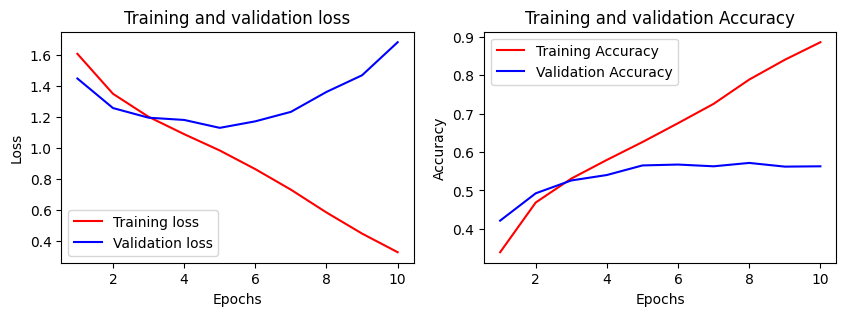

In [93]:
# Plot train/val results
visualize_loss_and_acc(
    train_loss_history_extended_cnn, train_acc_history_extended_cnn,
    valid_loss_history_extended_cnn, valid_acc_history_extended_cnn)


Extended CNN Test Accuracy: 56.15624115482593
Extended CNN Test Loss: 1.612330132297107


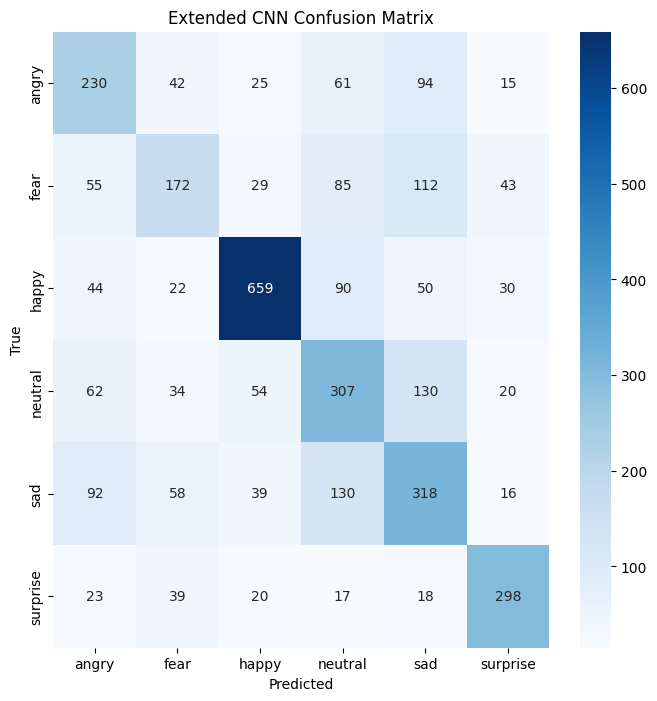

In [89]:
# Test ExtendedCNN
extended_cnn_accuracy, extended_cnn_loss, extended_cnn_labels, extended_cnn_predicted = test_model(
    extended_cnn_model, test_loader_c, criterion_extended_cnn, device)

# Report results
print('\nExtended CNN Test Accuracy:', extended_cnn_accuracy * 100)
print('Extended CNN Test Loss:', extended_cnn_loss)

# Plot confusion matrix for Extended CNN
plt.figure(figsize=(8, 8))
conf_matrix_extended_cnn = confusion_matrix(extended_cnn_labels, extended_cnn_predicted)
sns.heatmap(conf_matrix_extended_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Extended CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

 As you see with more Conv and FC layers the model performance increased. Because the model can extract better and more informative features from  data.
 - Test Accuracy: 56.16%

# Bonus2

In [95]:
# number of parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_cnn_parameters(model):
    num_params = 0
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            num_params += (layer.in_channels * layer.out_channels * layer.kernel_size[0] * layer.kernel_size[1] + 1) * layer.out_channels
        elif isinstance(layer, nn.Linear):
            num_params += (layer.in_features + 1) * layer.out_features
        elif isinstance(layer, nn.BatchNorm2d):
            num_params += 2 * layer.num_features
        elif isinstance(layer, nn.ConvTranspose2d):
            num_params += (layer.in_channels * layer.out_channels * layer.kernel_size[0] * layer.kernel_size[1] + 1) * layer.out_channels
        elif isinstance(layer, nn.Module):
            num_params += count_cnn_parameters(layer)
    return num_params


best_cnn_model = ExtendedCNN(num_classes=6)
total_cnn_parameters = count_cnn_parameters(best_cnn_model)
print(f"Total number of parameters in the CNN model: {total_cnn_parameters}")


best_mlp =  MLPWithHiddenLayer(input_size, hidden_size, output_size)

total_parameters = count_parameters(best_mlp)
print(f"Total number of parameters in the MLP model: {total_parameters}")


Total number of parameters in the CNN model: 13152678
Total number of parameters in the MLP model: 299366


# Part 5 - Dropout

In [103]:
# Define extended CNN model with Dropout
class ExtendedCNNWithDropout(nn.Module):
    def __init__(self, num_classes=6, dropout_prob=0.5):
        super(ExtendedCNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(p=dropout_prob)


    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the extended CNN model with Dropout
extended_cnn_model_with_dropout = ExtendedCNNWithDropout(num_classes=6, dropout_prob=0.5).to(device)

# Instantiate the loss function and optimizer for Extended CNN with Dropout
criterion_extended_cnn_with_dropout = nn.CrossEntropyLoss()
optimizer_extended_cnn_with_dropout = optim.Adam(extended_cnn_model_with_dropout.parameters(), lr=0.001)

# Lists to store training, validation, and test loss and accuracy for Extended CNN with Dropout
train_loss_history_extended_cnn_with_dropout = []
train_acc_history_extended_cnn_with_dropout = []
valid_loss_history_extended_cnn_with_dropout = []
valid_acc_history_extended_cnn_with_dropout = []
test_loss_history_extended_cnn_with_dropout = []
test_acc_history_extended_cnn_with_dropout = []

# Training loop for Extended CNN with Dropout
num_epochs = 10
for epoch in range(num_epochs):
    extended_cnn_model_with_dropout.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in tqdm.tqdm(train_loader_c):
        images, labels = batch['image'].to(device), batch['label'].to(device)

        optimizer_extended_cnn_with_dropout.zero_grad()
        outputs = extended_cnn_model_with_dropout(images)
        loss = criterion_extended_cnn_with_dropout(outputs, labels)
        loss.backward()
        optimizer_extended_cnn_with_dropout.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop for Extended CNN with Dropout
    extended_cnn_model_with_dropout.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for batch in valid_loader_c:
            images, labels = batch['image'].to(device), batch['label'].to(device)

            outputs = extended_cnn_model_with_dropout(images)
            loss = criterion_extended_cnn_with_dropout(outputs, labels)

            total_valid_loss += loss.item()
            _, predicted_valid = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted_valid == labels).sum().item()

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_accuracy = correct_valid / total_valid

    # Print and store results for Extended CNN with Dropout
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy * 100:.2f}%, '
          f'Validation Loss: {avg_valid_loss:.4f}, '
          f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    train_loss_history_extended_cnn_with_dropout.append(avg_train_loss)
    train_acc_history_extended_cnn_with_dropout.append(train_accuracy)
    valid_loss_history_extended_cnn_with_dropout.append(avg_valid_loss)
    valid_acc_history_extended_cnn_with_dropout.append(valid_accuracy)

100%|██████████| 442/442 [00:14<00:00, 30.19it/s]


Epoch [1/10], Train Loss: 1.6285, Train Accuracy: 32.07%, Validation Loss: 1.4520, Validation Accuracy: 41.00%


100%|██████████| 442/442 [00:16<00:00, 26.51it/s]


Epoch [2/10], Train Loss: 1.3944, Train Accuracy: 44.22%, Validation Loss: 1.3039, Validation Accuracy: 48.64%


100%|██████████| 442/442 [00:14<00:00, 30.50it/s]


Epoch [3/10], Train Loss: 1.2686, Train Accuracy: 50.08%, Validation Loss: 1.2771, Validation Accuracy: 49.49%


100%|██████████| 442/442 [00:14<00:00, 30.20it/s]


Epoch [4/10], Train Loss: 1.1601, Train Accuracy: 54.80%, Validation Loss: 1.1925, Validation Accuracy: 53.42%


100%|██████████| 442/442 [00:14<00:00, 29.66it/s]


Epoch [5/10], Train Loss: 1.0521, Train Accuracy: 59.72%, Validation Loss: 1.1772, Validation Accuracy: 54.61%


100%|██████████| 442/442 [00:16<00:00, 26.67it/s]


Epoch [6/10], Train Loss: 0.9490, Train Accuracy: 63.93%, Validation Loss: 1.1839, Validation Accuracy: 56.48%


100%|██████████| 442/442 [00:14<00:00, 30.44it/s]


Epoch [7/10], Train Loss: 0.8220, Train Accuracy: 69.34%, Validation Loss: 1.2128, Validation Accuracy: 56.93%


100%|██████████| 442/442 [00:14<00:00, 30.39it/s]


Epoch [8/10], Train Loss: 0.7028, Train Accuracy: 73.87%, Validation Loss: 1.2755, Validation Accuracy: 57.07%


100%|██████████| 442/442 [00:15<00:00, 28.27it/s]


Epoch [9/10], Train Loss: 0.5843, Train Accuracy: 78.80%, Validation Loss: 1.3903, Validation Accuracy: 57.41%


100%|██████████| 442/442 [00:15<00:00, 28.92it/s]


Epoch [10/10], Train Loss: 0.4855, Train Accuracy: 82.37%, Validation Loss: 1.5332, Validation Accuracy: 56.76%


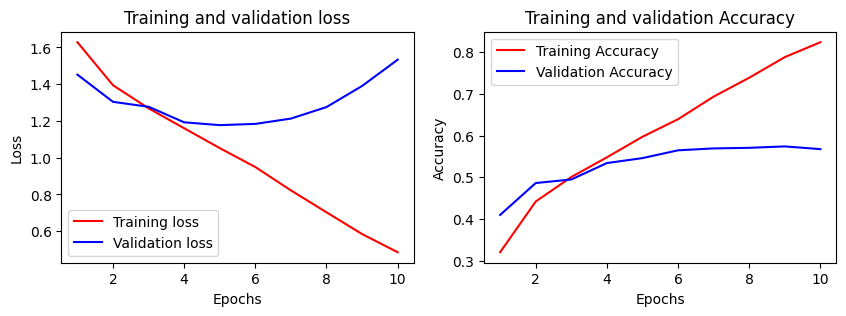

In [104]:
# Plot train/val results
visualize_loss_and_acc(
    train_loss_history_extended_cnn_with_dropout,
    train_acc_history_extended_cnn_with_dropout,
    valid_loss_history_extended_cnn_with_dropout,
    valid_acc_history_extended_cnn_with_dropout)


Extended CNN with Dropout Test Accuracy: 55.81658647042174
Extended CNN with Dropout Test Loss: 1.5987176490681512


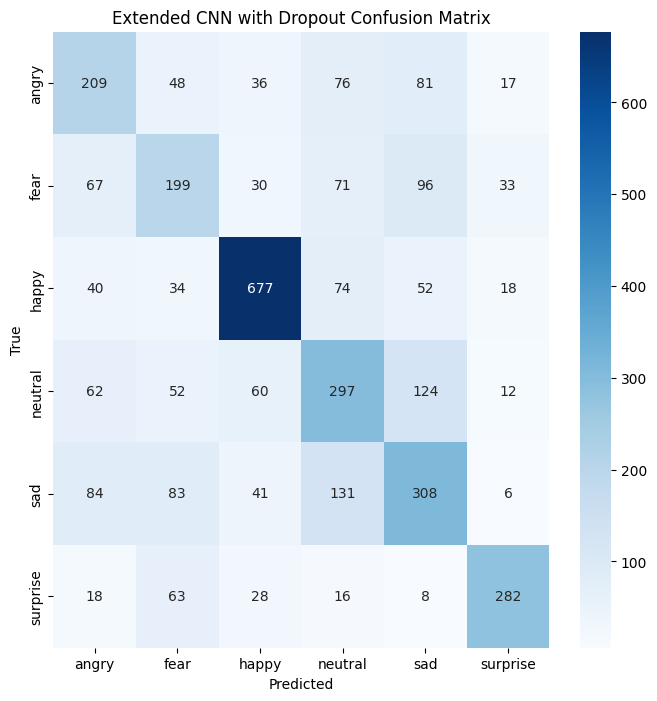

In [105]:
# Test loop for Extended CNN with Dropout
extended_cnn_with_dropout_accuracy, extended_cnn_with_dropout_loss, _, _ = test_model(
    extended_cnn_model_with_dropout, test_loader_c, criterion_extended_cnn_with_dropout, device)

# Report results for Extended CNN with Dropout
print('\nExtended CNN with Dropout Test Accuracy:', extended_cnn_with_dropout_accuracy * 100)
print('Extended CNN with Dropout Test Loss:', extended_cnn_with_dropout_loss)

# Plot confusion matrix for Extended CNN with Dropout
plt.figure(figsize=(8, 8))
extended_cnn_with_dropout_labels, extended_cnn_with_dropout_predicted = test_model(
    extended_cnn_model_with_dropout, test_loader_c, criterion_extended_cnn_with_dropout, device)[2:]

conf_matrix_extended_cnn_with_dropout = confusion_matrix(extended_cnn_with_dropout_labels, extended_cnn_with_dropout_predicted)

sns.heatmap(conf_matrix_extended_cnn_with_dropout, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)

plt.title('Extended CNN with Dropout Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Dropout is a regularization method that helps us to get rid of overfittng. Dropout randomly turns off (setting to zero) a proportion of the neurons during training. This prevents the model from becoming too reliant on specific neurons. So the model has better generalization and the performance in Validation and test is better.

 - Test Accuracy: 56%

# Bonus3

## Regularizaion Methodes
-  Weight Decay (L2 Regularization):

 - Explanation: Weight decay, also known as L2 regularization, adds the squared sum of the weights to the loss function. This penalizes large weights, discouraging the network from relying too much on specific features. It helps prevent overfitting by keeping the weights closer to zero.

 - Use Case: Weight decay is effective for preventing overfitting when there are many parameters in the model, such as in deep neural networks.


- Batch Normalization:

  - Explanation: Batch Normalization is a technique that normalizes the input of each layer in a mini-batch by subtracting the batch mean and dividing by the batch standard deviation. It introduces learnable parameters (gamma and beta) to scale and shift the normalized values. Batch Normalization not only improves convergence but also acts as a form of regularization by reducing internal covariate shift.

  - Use Case: Batch Normalization is commonly used in deep neural networks to stabilize and accelerate training, as well as to provide a form of regularization.


- DropConnect:

  - Explanation: DropConnect is an extension of dropout where, instead of dropping out individual neurons, entire connections are dropped during training. This means that the weights associated with a connection can be set to zero with a certain probability. DropConnect acts as a more fine-grained form of dropout.

  - Use Case: DropConnect is used in deep neural networks to prevent overfitting and enhance model generalization. It is particularly relevant in scenarios where dropout may be too aggressive.